In [1]:
# This notebook is for diffusion parcellation using HCPMMP cortical parcellation matrix and gradient approach for HCP 7Tsubj7TDWI subjects (N=173).

# Includes:
#     Connectivity matrix
#     Gradients calculation
#     Variance explained
#     BF gradient weighted Cortical Projection
#     Cortical RS Network associated to Upper and Lower 25% and 10% of BF gradient
#     Upper and Lower 25% and 10% of BF gradient cortical projection
#     Gradient x Atlas subregion comparison

In [4]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import plotly.graph_objects as go

### Setting the path

In [ ]:
main_path = "/srv/khan/users/sudesnac/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [ ]:
# get the current notebook path
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Diff_7Tsubj7TDWI/"
fig_path = main_path + "/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/"

### Get the connectivity matrix

In [5]:
# load npz data
data = load(data_path + 'tpl-MNI152NLin6Asym_label-fullBF_desc-concat_from-7Tsubj7TDWI_connMap-modified.npz')
correlation = data['conn_group']

In [6]:
# Average correlation matrix
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

In [7]:
# Reshape and concatenate subjects
corr = np.moveaxis(correlation,0,2)
corr_concat = corr.reshape([corr.shape[0],corr.shape[1]*corr.shape[2]])
corr_concat += 1 # Spectral clustering doesn't like negative input apparantly, or square
corr_concat[np.isnan(corr_concat)] = 1

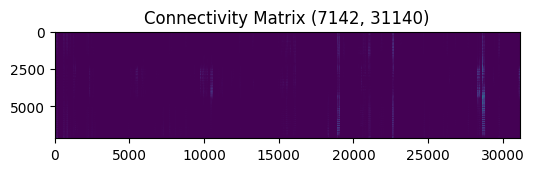

In [8]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_concat)
ax.set_title('Connectivity Matrix {}'.format(corr_concat.shape))
plt.show()

### Calculate Gradient

In [9]:
#Average data
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=10, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avg))

GradientMaps(kernel='normalized_angle', random_state=0)


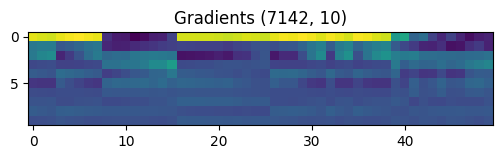

In [9]:
# Plot this gradients.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

In [10]:
# save the gradient
pd.DataFrame(gm.gradients_).to_csv(results_path + 'Diff_7Tsubj7TDWI_gradients_seed-BASF_0p7mm.csv', index=False)

In [11]:
# save the BF gradients niftis
# get seed data
seed_file = (data_path + 'fullBF_B_MNI152NLin6Asym_mask.nii.gz')
seed = nib.load(seed_file)
seed_vol = seed.get_fdata()
mask = data['mask']
affine = data['affine']

for gradi in range(5):

    grad_vol = np.zeros(mask.shape)
    grad_vol[mask > 0] = gm.gradients_[:,gradi]
    
    grad_nib = nib.Nifti1Image(grad_vol,affine,header=seed.header)
    grad_nib.to_filename(results_path + f'Diff_7Tsubj7TDWI_gradient_{gradi}.nii.gz')

### Calculate Variance

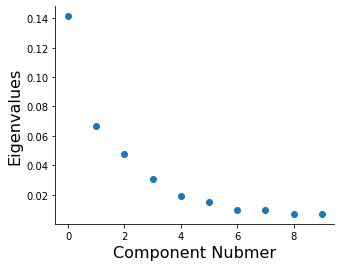

In [12]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Nubmer', fontsize=16)
ax.set_ylabel('Eigenvalues', fontsize=16)
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_Gradient_eiganvalue.png', dpi=300, bbox_inches='tight')
plt.show()

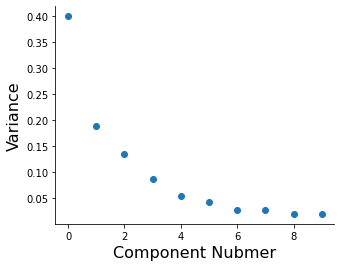

In [13]:
vals = gm.lambdas_ / np.sum(gm.lambdas_)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(vals.size), vals)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Nubmer', fontsize=16)
ax.set_ylabel('Variance', fontsize=16)
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_Gradient_variance.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualize Gradients

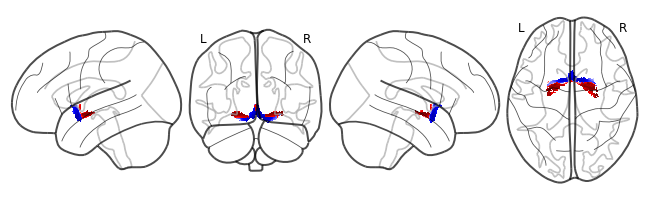

In [14]:
gradi = 0
grad_nib = nib.load(results_path + f'Diff_7Tsubj7TDWI_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('seismic')
plot_glass_brain(grad_nib, colorbar=False, display_mode='lyrz', plot_abs=False, cmap=color)
#title=(f'Gradient '+ str(gradi+1))
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_Gradient_'+ str(gradi+1)+'.png',dpi=300)

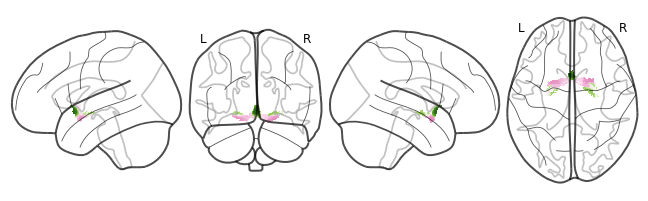

In [15]:
gradi = 1
grad_nib = nib.load(results_path + f'Diff_7Tsubj7TDWI_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('PiYG')
plot_glass_brain(grad_nib, colorbar=False, display_mode='lyrz', plot_abs=False, cmap=color)
#title=(f'Gradient '+ str(gradi+1))
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_Gradient_'+ str(gradi+1)+'.png',dpi=300)

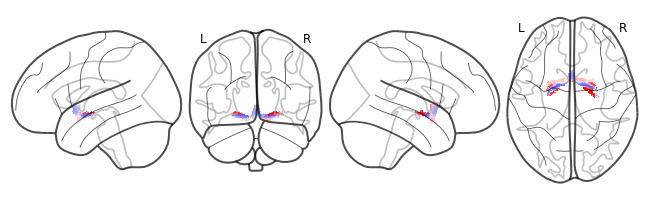

In [16]:
gradi = 2
grad_nib = nib.load(results_path + f'Diff_7Tsubj7TDWI_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('bwr')
plot_glass_brain(grad_nib, colorbar=False, display_mode='lyrz', plot_abs=False, cmap=color)
#title=(f'Gradient '+ str(gradi+1))
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_Gradient_'+ str(gradi+1)+'.png',dpi=300)

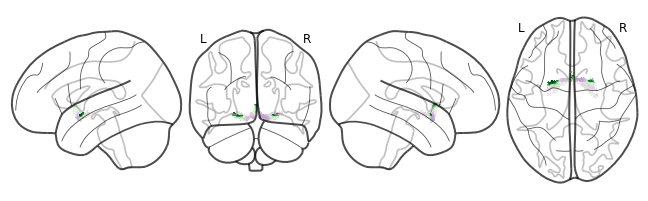

In [17]:
gradi = 3
grad_nib = nib.load(results_path + f'Diff_7Tsubj7TDWI_gradient_{gradi}.nii.gz')
color = matplotlib.cm.get_cmap('PRGn')
plot_glass_brain(grad_nib, colorbar=False, display_mode='lyrz', plot_abs=False, cmap=color)
#title=(f'Gradient '+ str(gradi+1))
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_Gradient_'+ str(gradi+1)+'.png',dpi=300)

In [18]:
# Load gradient niftis
G1 = nib.load(results_path + 'Diff_7Tsubj7TDWI_gradient_0.nii.gz').get_fdata()
G2 = nib.load(results_path + 'Diff_7Tsubj7TDWI_gradient_1.nii.gz').get_fdata()

In [19]:
# Find non-zero volume indices 
G1_idx = np.argwhere(G1)
G2_idx = np.argwhere(G1)

In [20]:
# Gradient values per index
G1_values = G1[G1_idx[:,0], G1_idx[:,1], G1_idx[:,2]].flatten()
G2_values = G2[G2_idx[:,0], G2_idx[:,1], G2_idx[:,2]].flatten()

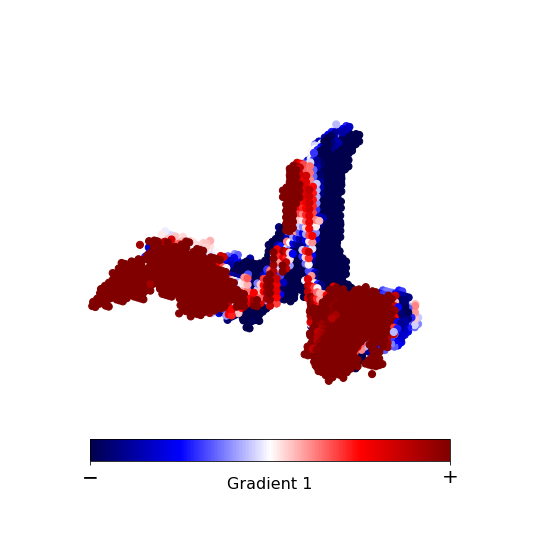

In [21]:
# Plot using 3D scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.dist=10
ax.set_axis_off()

ax.scatter(
    G1_idx[:,0],
    G1_idx[:,1],
    G1_idx[:,2],
    s=50, alpha=1,
    cmap='seismic', vmin=-0.1, vmax=0.1, 
    c=G1_values
)

# Add legend    
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.seismic), ticks=[-1, 1],
                  cax=cb_ax, orientation='horizontal')
cb.set_label("Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20) 

plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_Gradient_1_scatterplot.png', dpi=300, bbox_inches='tight')
plt.show()

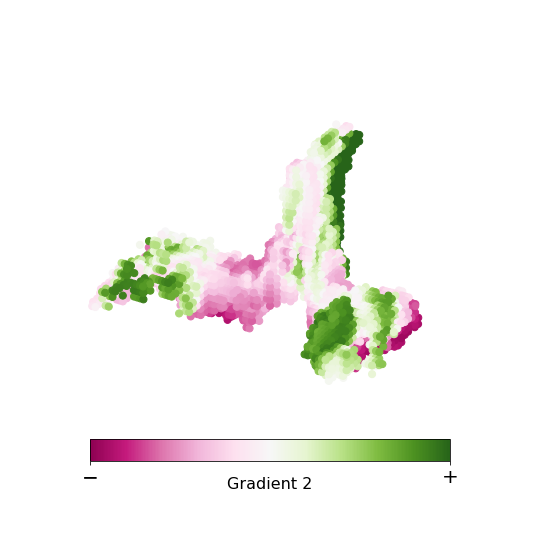

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.dist=10
ax.set_axis_off()

ax.scatter(
    G1_idx[:,0],
    G1_idx[:,1],
    G1_idx[:,2],
    s=50, alpha=1,
    cmap='PiYG', vmin=-0.1, vmax=0.1, 
    c=G2_values
)

# Add legend    
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.PiYG), ticks=[-1, 1],
                  cax=cb_ax, orientation='horizontal')
cb.set_label("Gradient 2", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20) 

plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_Gradient_2_scatterplot.png', dpi=300, bbox_inches='tight')
plt.show()

### BF-gradient weighted corical projection

In [10]:
# expand the corr_avg to match 360 cortical targets and get log-sclaed avgFC
corr_avgFC = np.concatenate((corr_avg,corr_avg), axis=1)
log_corr_avgFC = np.log(corr_avgFC)

In [11]:
# Gradient 1
G1_Ctx = np.zeros(corr_avgFC.shape)
for i in range(len(gm.gradients_[:,0])):
    G1_Ctx[i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,0]
G1fc = np.nanmean(G1_Ctx,axis=0).reshape([360,1])

In [12]:
# Gradient 2
G2_Ctx = np.zeros(corr_avgFC.shape)
for i in range(len(gm.gradients_[:,1])):
    G2_Ctx[i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,1]
G2fc = np.nanmean(G2_Ctx,axis=0).reshape([360,1])

In [13]:
# Gradient 3
G3_Ctx = np.zeros(corr_avgFC.shape)
for i in range(len(gm.gradients_[:,2])):
    G3_Ctx[i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,2]
G3fc = np.nanmean(G3_Ctx,axis=0).reshape([360,1])

In [14]:
# Gradient 4
G4_Ctx = np.zeros(corr_avgFC.shape)
for i in range(len(gm.gradients_[:,3])):
    G4_Ctx[i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,3]
G4fc = np.nanmean(G4_Ctx,axis=0).reshape([360,1])

In [15]:
np.savez(results_path + 'Diff_7Tsubj7TDWI_Gradient-weighted_CorticalConnectivity.npz', G1_Ctx=G1_Ctx, G2_Ctx=G2_Ctx, G3_Ctx=G3_Ctx, G4_Ctx=G4_Ctx, G1fc=G1fc, G2fc=G2fc, G3fc=G3fc, G4fc=G4fc)

In [6]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [14]:
# Need to make it to log scale!!
G1cortex = map_to_labels(G1fc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2cortex = map_to_labels(G2fc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G3cortex = map_to_labels(G3fc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4cortex = map_to_labels(G4fc.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [15]:
# Plot on the surface and save as fig - Grad 1.
plot_hemispheres(surf_lh, surf_rh, array_name=[G1cortex], label_text=['Gradient 1'],
    size=(800, 200),  cmap=['seismic'], color_bar=True, embed_nb=True, color_range='sym', screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad1_weighted_cortex.png' )

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad1_weighted_cortex.png'

In [16]:
# Plot on the surface and save as fig - Grad 2.
plot_hemispheres(surf_lh, surf_rh, array_name=[G2cortex], label_text=['Gradient 2'],
    size=(800,200),  cmap=['PiYG'], color_bar=True, embed_nb=True, color_range='sym', screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad2_weighted_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad2_weighted_cortex.png'

In [36]:
# Plot on the surface and save as fig - Grad 3.
plot_hemispheres(surf_lh, surf_rh, array_name=[G3cortex], label_text=['Grad 3'],
    size=(900,300),  cmap=['bwr'], color_bar=True, embed_nb=True, color_range='sym', screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad3_weighted_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad3_weighted_cortex.png'

In [37]:
# Plot on the surface and save as fig - Grad 4.
plot_hemispheres(surf_lh, surf_rh, array_name=[G4cortex], label_text=['Grad 4'],
    size=(900,300),  cmap=['PRGn'], color_bar=True, embed_nb=True, color_range='sym', screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad4_weighted_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad4_weighted_cortex.png'

In [38]:
# Save the cortical projection as gii files
G_cortex = [G1cortex, G2cortex, G3cortex, G4cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_weighted_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_weighted_R_fsa-10k.gii')

### Visualize BF-gradient weighted cortical projection

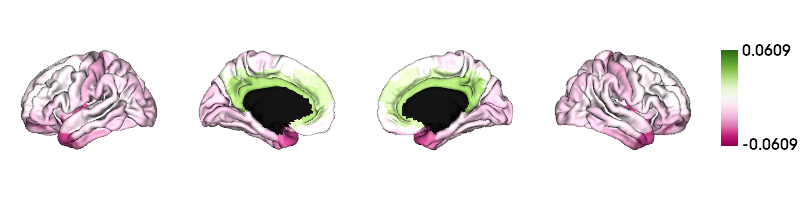

In [8]:
grad_L = images.load_gifti(results_path+'Diff_7Tsubj7TDWI_Gradient-2_weighted_L_fsa-10k.gii')
grad_R = images.load_gifti(results_path+'Diff_7Tsubj7TDWI_Gradient-2_weighted_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['PiYG'], color_range='sym', color_bar=True, embed_nb=True)

### Networks associated with upper and lower end of gradients

In [41]:
# load and prepare the label file
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [42]:
corr_avgFC_df = pd.DataFrame(corr_avgFC)
log_corr_avgFC_df = pd.DataFrame(log_corr_avgFC)
grad_mask_matrix = np.zeros(len(gm.gradients_[:,0]))
grad1_data = gm.gradients_[:,0]
grad2_data = gm.gradients_[:,1]
grad3_data = gm.gradients_[:,2]
grad4_data = gm.gradients_[:,3]

In [43]:
# Upper 10 and 25%
grad1_25upper = grad1_data >=  np.quantile(grad1_data, q=0.75) 
grad2_25upper = grad2_data >=  np.quantile(grad2_data, q=0.75) 
grad3_25upper = grad3_data >=  np.quantile(grad3_data, q=0.75) 
grad4_25upper = grad4_data >=  np.quantile(grad4_data, q=0.75) 
grad1_10upper = grad1_data >=  np.quantile(grad1_data, q=0.90) 
grad2_10upper = grad2_data >=  np.quantile(grad2_data, q=0.90) 
grad3_10upper = grad3_data >=  np.quantile(grad3_data, q=0.90) 
grad4_10upper = grad4_data >=  np.quantile(grad4_data, q=0.90) 
grad1_25upper_idx = np.where(grad1_25upper)[0]
grad2_25upper_idx = np.where(grad2_25upper)[0]
grad3_25upper_idx = np.where(grad3_25upper)[0]
grad4_25upper_idx = np.where(grad4_25upper)[0]
grad1_10upper_idx = np.where(grad1_10upper)[0]
grad2_10upper_idx = np.where(grad2_10upper)[0]
grad3_10upper_idx = np.where(grad3_10upper)[0]
grad4_10upper_idx = np.where(grad4_10upper)[0]

In [44]:
# Lower 10 and 25%
grad1_25lower = grad1_data <= np.quantile(grad1_data, q=0.25)
grad2_25lower = grad2_data <= np.quantile(grad2_data, q=0.25)
grad3_25lower = grad3_data <= np.quantile(grad3_data, q=0.25)
grad4_25lower = grad4_data <= np.quantile(grad4_data, q=0.25)
grad1_10lower = grad1_data <= np.quantile(grad1_data, q=0.10)
grad2_10lower = grad2_data <= np.quantile(grad2_data, q=0.10)
grad3_10lower = grad3_data <= np.quantile(grad3_data, q=0.10)
grad4_10lower = grad4_data <= np.quantile(grad4_data, q=0.10)
grad1_25lower_idx = np.where(grad1_25lower)[0]
grad2_25lower_idx = np.where(grad2_25lower)[0]
grad3_25lower_idx = np.where(grad3_25lower)[0]
grad4_25lower_idx = np.where(grad4_25lower)[0]
grad1_10lower_idx = np.where(grad1_10lower)[0]
grad2_10lower_idx = np.where(grad2_10lower)[0]
grad3_10lower_idx = np.where(grad3_10lower)[0]
grad4_10lower_idx = np.where(grad4_10lower)[0]

In [45]:
# Upper gradient log avgFC
grad1_25upperFC = log_corr_avgFC_df.iloc[grad1_25upper_idx,:]
grad2_25upperFC = log_corr_avgFC_df.iloc[grad2_25upper_idx,:]
grad3_25upperFC = log_corr_avgFC_df.iloc[grad3_25upper_idx,:]
grad4_25upperFC = log_corr_avgFC_df.iloc[grad4_25upper_idx,:]
grad1_10upperFC = log_corr_avgFC_df.iloc[grad1_10upper_idx,:]
grad2_10upperFC = log_corr_avgFC_df.iloc[grad2_10upper_idx,:]
grad3_10upperFC = log_corr_avgFC_df.iloc[grad3_10upper_idx,:]
grad4_10upperFC = log_corr_avgFC_df.iloc[grad4_10upper_idx,:]

In [46]:
# Lower gradient FC
grad1_25lowerFC = log_corr_avgFC_df.iloc[grad1_25lower_idx,:]
grad2_25lowerFC = log_corr_avgFC_df.iloc[grad2_25lower_idx,:]
grad3_25lowerFC = log_corr_avgFC_df.iloc[grad3_25lower_idx,:]
grad4_25lowerFC = log_corr_avgFC_df.iloc[grad4_25lower_idx,:]
grad1_10lowerFC = log_corr_avgFC_df.iloc[grad1_10lower_idx,:]
grad2_10lowerFC = log_corr_avgFC_df.iloc[grad2_10lower_idx,:]
grad3_10lowerFC = log_corr_avgFC_df.iloc[grad3_10lower_idx,:]
grad4_10lowerFC = log_corr_avgFC_df.iloc[grad4_10lower_idx,:]

In [47]:
grad1upper25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad1_25upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad1upper25_matrix.append(net_mean)

In [48]:
grad1lower25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad1_25lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad1lower25_matrix.append(net_mean)

In [49]:
grad1upper10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad1_10upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad1upper10_matrix.append(net_mean)

In [50]:
grad1lower10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad1_10lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad1lower10_matrix.append(net_mean)

In [51]:
grad2upper25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad2_25upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad2upper25_matrix.append(net_mean)

In [52]:
grad2lower25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad2_25lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad2lower25_matrix.append(net_mean)

In [53]:
grad2upper10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad2_10upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad2upper10_matrix.append(net_mean)

In [54]:
grad2lower10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad2_10lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad2lower10_matrix.append(net_mean)

In [55]:
grad3upper25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad3_25upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad3upper25_matrix.append(net_mean)

In [56]:
grad3lower25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad3_25lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad3lower25_matrix.append(net_mean)

In [57]:
grad3upper10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad3_10upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad3upper10_matrix.append(net_mean)

In [58]:
grad3lower10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad3_10lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad3lower10_matrix.append(net_mean)

In [59]:
grad4upper25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad4_25upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad4upper25_matrix.append(net_mean)

In [60]:
grad4lower25_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad4_25lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad4lower25_matrix.append(net_mean)

In [61]:
grad4upper10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad4_10upperFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad4upper10_matrix.append(net_mean)

In [62]:
grad4lower10_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = grad4_10lowerFC.iloc[:,net_inds]
        net_mean.append(net_con_df.to_numpy().mean())

grad4lower10_matrix.append(net_mean)

In [63]:
grad1upper25=np.array(grad1upper25_matrix)
grad1lower25=np.array(grad1lower25_matrix)
grad2upper25=np.array(grad2upper25_matrix)
grad2lower25=np.array(grad2lower25_matrix)
grad3upper25=np.array(grad3upper25_matrix)
grad3lower25=np.array(grad3lower25_matrix)
grad4upper25=np.array(grad4upper25_matrix)
grad4lower25=np.array(grad4lower25_matrix)
grad1upper10=np.array(grad1upper10_matrix)
grad1lower10=np.array(grad1lower10_matrix)
grad2upper10=np.array(grad2upper10_matrix)
grad2lower10=np.array(grad2lower10_matrix)
grad3upper10=np.array(grad3upper10_matrix)
grad3lower10=np.array(grad3lower10_matrix)
grad4upper10=np.array(grad4upper10_matrix)
grad4lower10=np.array(grad4lower10_matrix)

In [65]:
grad1_25_network_df = pd.DataFrame({'networks':networks, 'Grad1 25% Upper':grad1upper25.reshape([7]), 'Grad1 25% Lower':grad1lower25.reshape([7])})
grad1_10_network_df = pd.DataFrame({'networks':networks, 'Grad1 10% Upper':grad1upper10.reshape([7]), 'Grad1 10% Lower':grad1lower10.reshape([7])})
grad2_25_network_df = pd.DataFrame({'networks':networks, 'Grad2 25% Upper':grad2upper25.reshape([7]), 'Grad2 25% Lower':grad2lower25.reshape([7])})
grad2_10_network_df = pd.DataFrame({'networks':networks, 'Grad2 10% Upper':grad2upper10.reshape([7]), 'Grad2 10% Lower':grad2lower10.reshape([7])})
grad3_25_network_df = pd.DataFrame({'networks':networks, 'Grad3 25% Upper':grad3upper25.reshape([7]), 'Grad3 25% Lower':grad3lower25.reshape([7])})
grad3_10_network_df = pd.DataFrame({'networks':networks, 'Grad3 10% Upper':grad3upper10.reshape([7]), 'Grad3 10% Lower':grad3lower10.reshape([7])})
grad4_25_network_df = pd.DataFrame({'networks':networks, 'Grad4 25% Upper':grad4upper25.reshape([7]), 'Grad4 25% Lower':grad4lower25.reshape([7])})
grad4_10_network_df = pd.DataFrame({'networks':networks, 'Grad4 10% Upper':grad4upper10.reshape([7]), 'Grad4 10% Lower':grad4lower10.reshape([7])})

In [66]:
pd.DataFrame(grad1_25_network_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient1_Upper&Lower_25%_network.csv', index=False)
pd.DataFrame(grad1_10_network_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient1_Upper&Lower_10%_network.csv', index=False)
pd.DataFrame(grad2_25_network_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient2_Upper&Lower_25%_network.csv', index=False)
pd.DataFrame(grad2_10_network_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient2_Upper&Lower_10%_network.csv', index=False)
pd.DataFrame(grad3_25_network_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient3_Upper&Lower_25%_network.csv', index=False)
pd.DataFrame(grad3_10_network_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient3_Upper&Lower_10%_network.csv', index=False)
pd.DataFrame(grad4_25_network_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient4_Upper&Lower_25%_network.csv', index=False)
pd.DataFrame(grad4_10_network_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient4_Upper&Lower_10%_network.csv', index=False)

In [1]:
grad1_25_network_df = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient1_Upper&Lower_25%_network.csv')
grad1_10_network_df = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient1_Upper&Lower_10%_network.csv')
grad2_25_network_df = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient2_Upper&Lower_25%_network.csv')
grad2_10_network_df = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient2_Upper&Lower_10%_network.csv')
grad3_25_network_df = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient3_Upper&Lower_25%_network.csv')
grad3_10_network_df = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient3_Upper&Lower_10%_network.csv')
grad4_25_network_df = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient4_Upper&Lower_25%_network.csv')
grad4_10_network_df = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient4_Upper&Lower_10%_network.csv')

NameError: name 'pd' is not defined

In [4]:
grad1_25_network_df

,networks,Grad1 25% Upper,Grad1 25% Lower
0,Visual,2.733813,1.466809
1,Somatomotor,1.794862,1.465186
2,Dorsal Attention,2.019109,1.201784
3,Ventral Attention,1.383223,1.552604
4,Default,1.787998,1.985880
5,Frontoparietal,1.444056,1.559284
6,Limbic,1.917177,1.886240


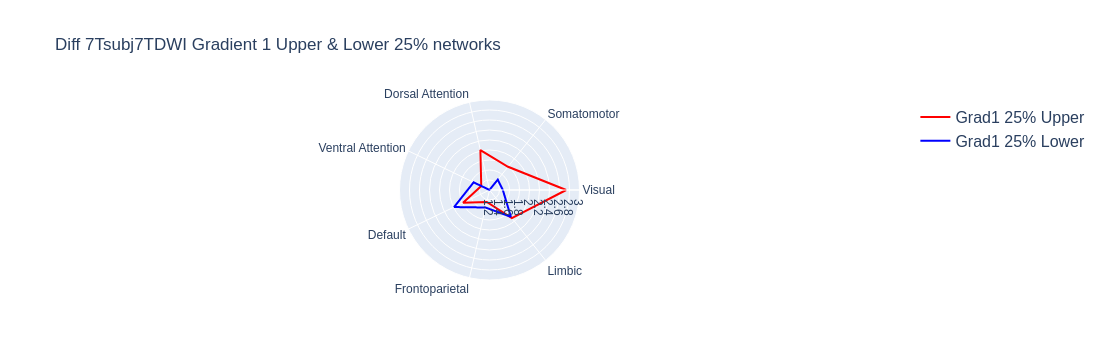

In [10]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad1_25_network_df['Grad1 25% Upper'].values.tolist() + grad1_25_network_df['Grad1 25% Upper'].values.tolist()[:1], theta=grad1_25_network_df['networks'].tolist() + grad1_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='Grad1 25% Upper'))
fig.add_trace(go.Scatterpolar(r=grad1_25_network_df['Grad1 25% Lower'].values.tolist() + grad1_25_network_df['Grad1 25% Lower'].values.tolist()[:1], theta=grad1_25_network_df['networks'].tolist() + grad1_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='Grad1 25% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.2, 3.0])),title = 'Diff 7Tsubj7TDWI Gradient 1 Upper & Lower 25% networks', showlegend=True, legend_font_size=16)

fig.show()
fig.write_image(fig_path+'Diff_7Tsubj7TDWI_Gradient1_Upper&Lower_25%_networks.png')

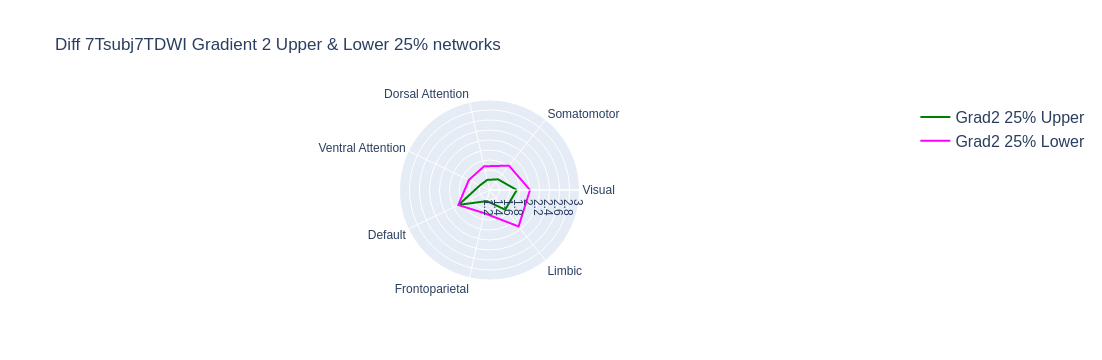

In [9]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad2_25_network_df['Grad2 25% Upper'].values.tolist() + grad2_25_network_df['Grad2 25% Upper'].values.tolist()[:1], theta=grad2_25_network_df['networks'].tolist() + grad2_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='Grad2 25% Upper'))
fig.add_trace(go.Scatterpolar(r=grad2_25_network_df['Grad2 25% Lower'].values.tolist() + grad2_25_network_df['Grad2 25% Lower'].values.tolist()[:1], theta=grad2_25_network_df['networks'].tolist() + grad2_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'fuchsia', name='Grad2 25% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.2, 3.0])),title = 'Diff 7Tsubj7TDWI Gradient 2 Upper & Lower 25% networks', showlegend=True, legend_font_size=16)

fig.show()
fig.write_image(fig_path+'Diff_7Tsubj7TDWI_Gradient2_Upper&Lower_25%_networks.png')

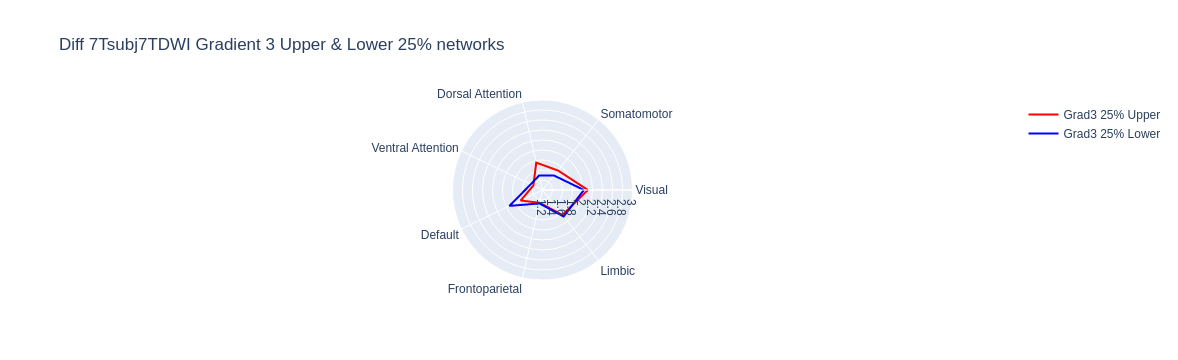

In [72]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad3_25_network_df['Grad3 25% Upper'].values.tolist() + grad3_25_network_df['Grad3 25% Upper'].values.tolist()[:1], theta=grad3_25_network_df['networks'].tolist() + grad3_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='Grad3 25% Upper'))
fig.add_trace(go.Scatterpolar(r=grad3_25_network_df['Grad3 25% Lower'].values.tolist() + grad3_25_network_df['Grad3 25% Lower'].values.tolist()[:1], theta=grad3_25_network_df['networks'].tolist() + grad3_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='Grad3 25% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.2, 3.0])),title = 'Diff 7Tsubj7TDWI Gradient 3 Upper & Lower 25% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_7Tsubj7TDWI_Gradient3_Upper&Lower_25%_networks.png')

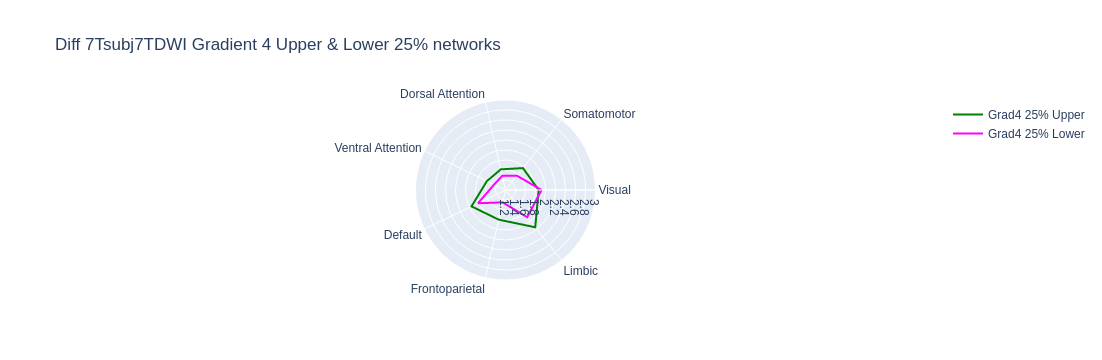

In [73]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad4_25_network_df['Grad4 25% Upper'].values.tolist() + grad4_25_network_df['Grad4 25% Upper'].values.tolist()[:1], theta=grad4_25_network_df['networks'].tolist() + grad4_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='Grad4 25% Upper'))
fig.add_trace(go.Scatterpolar(r=grad4_25_network_df['Grad4 25% Lower'].values.tolist() + grad4_25_network_df['Grad4 25% Lower'].values.tolist()[:1], theta=grad4_25_network_df['networks'].tolist() + grad4_25_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'fuchsia', name='Grad4 25% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.2, 3.0])),title = 'Diff 7Tsubj7TDWI Gradient 4 Upper & Lower 25% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_7Tsubj7TDWI_Gradient4_Upper&Lower_25%_networks.png')

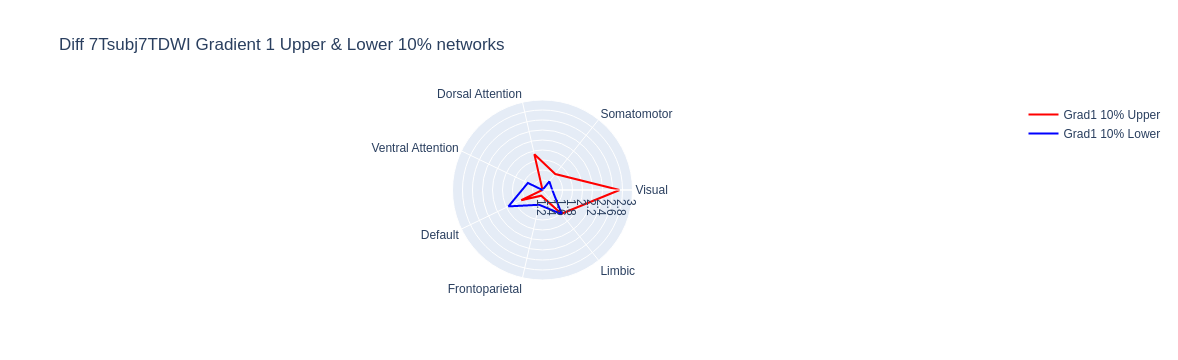

In [74]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad1_10_network_df['Grad1 10% Upper'].values.tolist() + grad1_10_network_df['Grad1 10% Upper'].values.tolist()[:1], theta=grad1_10_network_df['networks'].tolist() + grad1_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='Grad1 10% Upper'))
fig.add_trace(go.Scatterpolar(r=grad1_10_network_df['Grad1 10% Lower'].values.tolist() + grad1_10_network_df['Grad1 10% Lower'].values.tolist()[:1], theta=grad1_10_network_df['networks'].tolist() + grad1_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='Grad1 10% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.2, 3.0])),title = 'Diff 7Tsubj7TDWI Gradient 1 Upper & Lower 10% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_7Tsubj7TDWI_Gradient1_Upper&Lower_10%_networks.png')

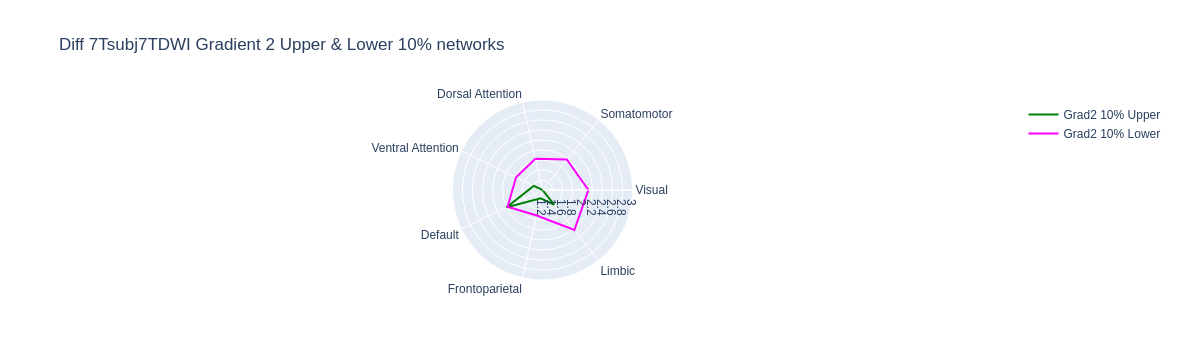

In [75]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad2_10_network_df['Grad2 10% Upper'].values.tolist() + grad2_10_network_df['Grad2 10% Upper'].values.tolist()[:1], theta=grad2_10_network_df['networks'].tolist() + grad2_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='Grad2 10% Upper'))
fig.add_trace(go.Scatterpolar(r=grad2_10_network_df['Grad2 10% Lower'].values.tolist() + grad2_10_network_df['Grad2 10% Lower'].values.tolist()[:1], theta=grad2_10_network_df['networks'].tolist() + grad2_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'fuchsia', name='Grad2 10% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.2, 3.0])),title = 'Diff 7Tsubj7TDWI Gradient 2 Upper & Lower 10% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_7Tsubj7TDWI_Gradient2_Upper&Lower_10%_networks.png')

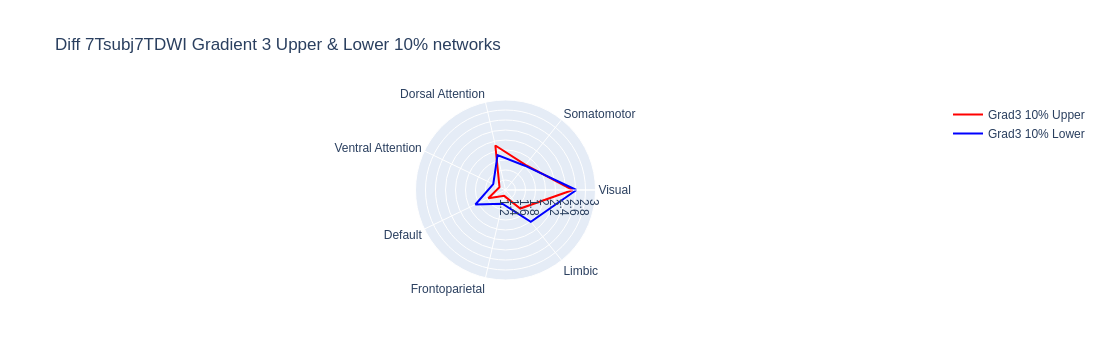

In [76]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad3_10_network_df['Grad3 10% Upper'].values.tolist() + grad3_10_network_df['Grad3 10% Upper'].values.tolist()[:1], theta=grad3_10_network_df['networks'].tolist() + grad3_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='Grad3 10% Upper'))
fig.add_trace(go.Scatterpolar(r=grad3_10_network_df['Grad3 10% Lower'].values.tolist() + grad3_10_network_df['Grad3 10% Lower'].values.tolist()[:1], theta=grad3_10_network_df['networks'].tolist() + grad3_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='Grad3 10% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.2, 3.0])),title = 'Diff 7Tsubj7TDWI Gradient 3 Upper & Lower 10% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_7Tsubj7TDWI_Gradient3_Upper&Lower_10%_networks.png')

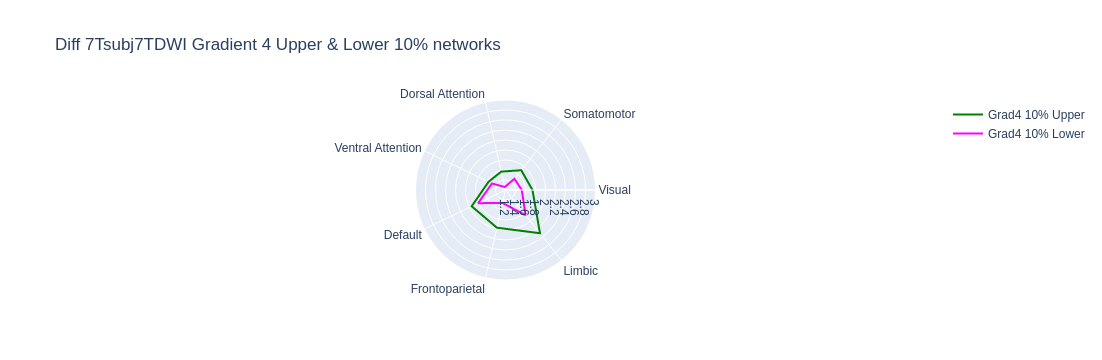

In [77]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=grad4_10_network_df['Grad4 10% Upper'].values.tolist() + grad4_10_network_df['Grad4 10% Upper'].values.tolist()[:1], theta=grad4_10_network_df['networks'].tolist() + grad4_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='Grad4 10% Upper'))
fig.add_trace(go.Scatterpolar(r=grad4_10_network_df['Grad4 10% Lower'].values.tolist() + grad4_10_network_df['Grad4 10% Lower'].values.tolist()[:1], theta=grad4_10_network_df['networks'].tolist() + grad4_10_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'fuchsia', name='Grad4 10% Lower'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[1.2, 3.0])),title = 'Diff 7Tsubj7TDWI Gradient 4 Upper & Lower 10% networks', showlegend=True)

fig.show()
fig.write_image(fig_path+'Diff_7Tsubj7TDWI_Gradient4_Upper&Lower_10%_networks.png')

### Upper and Lower gradient cortical projection

In [78]:
# Upper
grad1_25upperFCavg = np.nanmean(grad1_25upperFC,axis=0).reshape([360,1])
grad1_10upperFCavg = np.nanmean(grad1_10upperFC,axis=0).reshape([360,1])
grad2_25upperFCavg = np.nanmean(grad2_25upperFC,axis=0).reshape([360,1])
grad2_10upperFCavg = np.nanmean(grad2_10upperFC,axis=0).reshape([360,1])

In [79]:
grad3_25upperFCavg = np.nanmean(grad3_25upperFC,axis=0).reshape([360,1])
grad3_10upperFCavg = np.nanmean(grad3_10upperFC,axis=0).reshape([360,1])
grad4_25upperFCavg = np.nanmean(grad4_25upperFC,axis=0).reshape([360,1])
grad4_10upperFCavg = np.nanmean(grad4_10upperFC,axis=0).reshape([360,1])

In [80]:
# Lower
grad1_25lowerFCavg = np.nanmean(grad1_25lowerFC,axis=0).reshape([360,1])
grad1_10lowerFCavg = np.nanmean(grad1_10lowerFC,axis=0).reshape([360,1])
grad2_25lowerFCavg = np.nanmean(grad2_25lowerFC,axis=0).reshape([360,1])
grad2_10lowerFCavg = np.nanmean(grad2_10lowerFC,axis=0).reshape([360,1])

In [81]:
grad3_25lowerFCavg = np.nanmean(grad3_25lowerFC,axis=0).reshape([360,1])
grad3_10lowerFCavg = np.nanmean(grad3_10lowerFC,axis=0).reshape([360,1])
grad4_25lowerFCavg = np.nanmean(grad4_25lowerFC,axis=0).reshape([360,1])
grad4_10lowerFCavg = np.nanmean(grad4_10lowerFC,axis=0).reshape([360,1])

In [82]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [83]:
# Upper
G1upper25cortex = map_to_labels(grad1_25upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G1upper10cortex = map_to_labels(grad1_10upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2upper25cortex = map_to_labels(grad2_25upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2upper10cortex = map_to_labels(grad2_10upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [84]:
G3upper25cortex = map_to_labels(grad3_25upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G3upper10cortex = map_to_labels(grad3_10upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4upper25cortex = map_to_labels(grad4_25upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4upper10cortex = map_to_labels(grad4_10upperFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [85]:
# Lower
G1lower25cortex = map_to_labels(grad1_25lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G1lower10cortex = map_to_labels(grad1_10lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2lower25cortex = map_to_labels(grad2_25lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G2lower10cortex = map_to_labels(grad2_10lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [86]:
G3lower25cortex = map_to_labels(grad3_25lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G3lower10cortex = map_to_labels(grad3_10lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4lower25cortex = map_to_labels(grad4_25lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)
G4lower10cortex = map_to_labels(grad4_10lowerFCavg.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [87]:
# Plot on the surface and save the fig.
plot_hemispheres(surf_lh, surf_rh, array_name=[G1upper25cortex], label_text=['Grad1 upper 25%'],
    size=(800, 200),  cmap=['Reds'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad1_Upper25%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad1_Upper25%_cortex.png'

In [88]:
# Plot on the surface and save the fig.
plot_hemispheres(surf_lh, surf_rh, array_name=[G1upper10cortex], label_text=['Grad1 upper 10%'],
    size=(800, 200),  cmap=['Reds'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad1_Upper10%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad1_Upper10%_cortex.png'

In [89]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G1lower25cortex], label_text=['Grad1 lower 25%'],
    size=(800, 200),  cmap=['Blues'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad1_Lower25%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad1_Lower25%_cortex.png'

In [90]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G1lower10cortex], label_text=['Grad1 lower 10%'],
    size=(800, 200),  cmap=['Blues'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad1_Lower10%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad1_Lower10%_cortex.png'

In [91]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G2upper25cortex], label_text=['Grad2 upper 25%'],
    size=(800, 200),  cmap=['Greens'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad2_Upper25%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad2_Upper25%_cortex.png'

In [92]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G2upper10cortex], label_text=['Grad2 upper 10%'],
    size=(800, 200),  cmap=['Greens'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad2_Upper10%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad2_Upper10%_cortex.png'

In [93]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G2lower25cortex], label_text=['Grad2 lower 25%'],
    size=(800, 200),  cmap=['RdPu'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad2_Lower25%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad2_Lower25%_cortex.png'

In [94]:
plot_hemispheres(surf_lh, surf_rh, array_name=[G2lower10cortex], label_text=['Grad2 lower 10%'],
    size=(800, 200),  cmap=['RdPu'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Diff_7Tsubj7TDWI_Grad2_Lower10%_cortex.png')

'/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/HumanBF-Parcellation/results/figures/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Grad2_Lower10%_cortex.png'

In [95]:
# Save the cortical projection as gii files
# Upper 25%
G_cortex = [G1upper25cortex, G2upper25cortex, G3upper25cortex, G4upper25cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_Upper25%_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_Upper25%_R_fsa-10k.gii')

In [96]:
# Lower 25%
G_cortex = [G1lower25cortex, G2lower25cortex, G3lower25cortex, G4lower25cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_Lower25%_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_Lower25%_R_fsa-10k.gii')

In [97]:
# Upper 10%
G_cortex = [G1upper10cortex, G2upper10cortex, G3upper10cortex, G4upper10cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_Upper10%_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_Upper10%_R_fsa-10k.gii')

In [98]:
# Lower 10%
G_cortex = [G1lower10cortex, G2lower10cortex, G3lower10cortex, G4lower10cortex]

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_Lower10%_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_7Tsubj7TDWI_Gradient-'+str(g+1)+'_Lower10%_R_fsa-10k.gii')

### Visualize Upper and Lower gradient cortical projection

/home/ROBARTS/schakraborty/venv/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning:

Interactive mode requires 'panel'. Setting 'interactive=False'



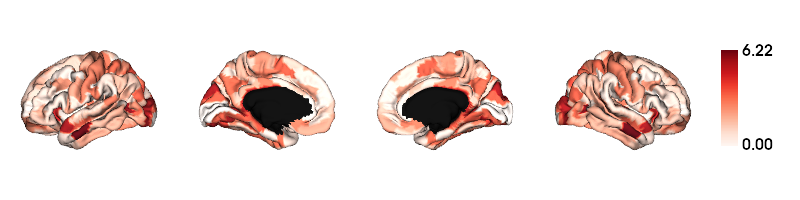

In [99]:
grad_L = images.load_gifti(results_path+'Diff_7Tsubj7TDWI_Gradient-1_Upper25%_L_fsa-10k.gii')
grad_R = images.load_gifti(results_path+'Diff_7Tsubj7TDWI_Gradient-1_Upper25%_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['Reds'], color_bar=True, embed_nb=True)